In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from ggplot import *


/home/ramon/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ramon/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/ramon/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [48]:
df_listing = pd.read_csv('../../data/listing_cleansed.csv')
TARGET = 'is_multihost'
df_listing['listings_per_host']=df_listing.groupby(["host_id"])["listing_id"].transform("count")
df_listing[TARGET]=np.where( df_listing.listings_per_host>1,'multi host','single host')
df_listing.host_id.isnull().sum()

0

In [49]:
df_listing.is_multihost.value_counts()

single host    7786
multi host     1422
Name: is_multihost, dtype: int64

## Greyscale patterns

In [50]:
df_pictures = pd.read_csv('../../data/df_pictures_listing.csv',index_col=0)


df_pictures=pd.merge(df_pictures,df_listing[['listing_id','is_multihost']],on='listing_id')

In [51]:
df_pictures.is_multihost.value_counts()

single host    3729
multi host     1155
Name: is_multihost, dtype: int64

In [52]:
from numpy.random import RandomState
n_row, n_col = 2,3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

hfont = {'fontname':'CMU Serif'} 

def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16, **hfont)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.Accent,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

In [53]:
def prepare_pictures_pca(group,name):
    X_data = group[cols].values
    n_samples, n_features = X_data.shape

    # global centering
    faces_centered = X_data - X_data.mean(axis=0)

    # local centering
    faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)
    print X_data.shape
    pca = PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True)
    pca.fit(faces_centered)
    components_ =pca.components_
    plot_gallery('Eigen pictures for '+str(name),
                 components_[:n_components])


In [54]:
cols = [c for c in df_pictures.columns if 'pix' in c]

(1155, 4096)
(3729, 4096)


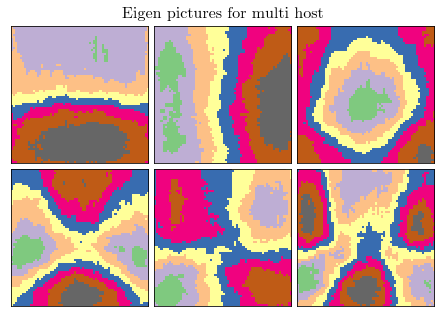

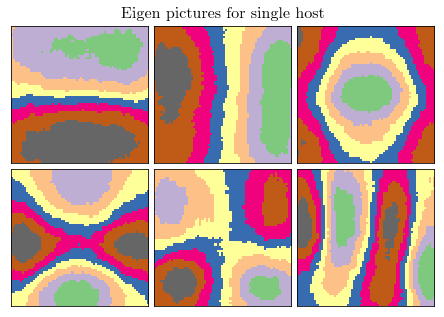

In [56]:
groupy_pictures= df_pictures.groupby('is_multihost')


for name,group in groupy_pictures:
    prepare_pictures_pca(group,name)


## PCA on greyscale

35.7423676536


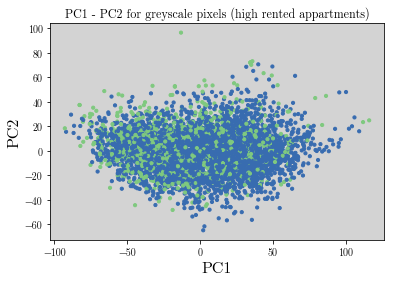

In [70]:
pca = PCA(n_components=50)
fig, plot = plt.subplots()
plot.set_facecolor('lightgrey')

X_train = scale(df_pictures[cols].values)
y_train = np.where(df_pictures['is_multihost']=='multi host',0,1)
z_train = 10


X_transformed = pca.fit_transform(X_train)

print pca.explained_variance_ratio_[:2].sum()*100


colors = plt.cm.Accent(scale(y_train))


plot.scatter(X_transformed[:, 0], X_transformed[:, 1], c=colors,s=z_train,alpha=1)

plot.set_ylabel('PC2', size=16, fontname='CMU Serif')
plot.set_xlabel('PC1', size=16, fontname='CMU Serif')
plot.set_title('PC1 - PC2 for greyscale pixels (high rented appartments)', size=12, **hfont)
for tick in plot.get_xticklabels():
    tick.set_fontname("CMU Serif")
    tick.set_fontsize(10)
for tick in plot.get_yticklabels():
    tick.set_fontname("CMU Serif")
    tick.set_fontsize(10)

df_pictures['PC_1'] = X_transformed[:, 0]

df_pictures['PC_2'] = X_transformed[:, 1]

## Colors Rainbows

In [72]:
df_colors_cluster=pd.read_csv('../../data/df_colours_clusters.csv')
df_colors_cluster=df_pictures=pd.merge(df_colors_cluster,df_listing[['listing_id','is_multihost']],on='listing_id')

In [73]:
def get_clusters_colors(df,availability_90, higher=True,n_clusters=10):
    
    
    X_colors_centroids = df[['Centroid_R_1','Centroid_G_1','Centroid_B_1']].values
    clt = KMeans(n_clusters = n_clusters)
    clt.fit(X_colors_centroids)
    list_col=[]

    for i in range(0,clt.cluster_centers_.shape[0]):
        arr_col = clt.cluster_centers_[i]/255
        
        list_col.append((arr_col.tolist()))
        
    list_col.sort()
    return list_col

multi host
single host


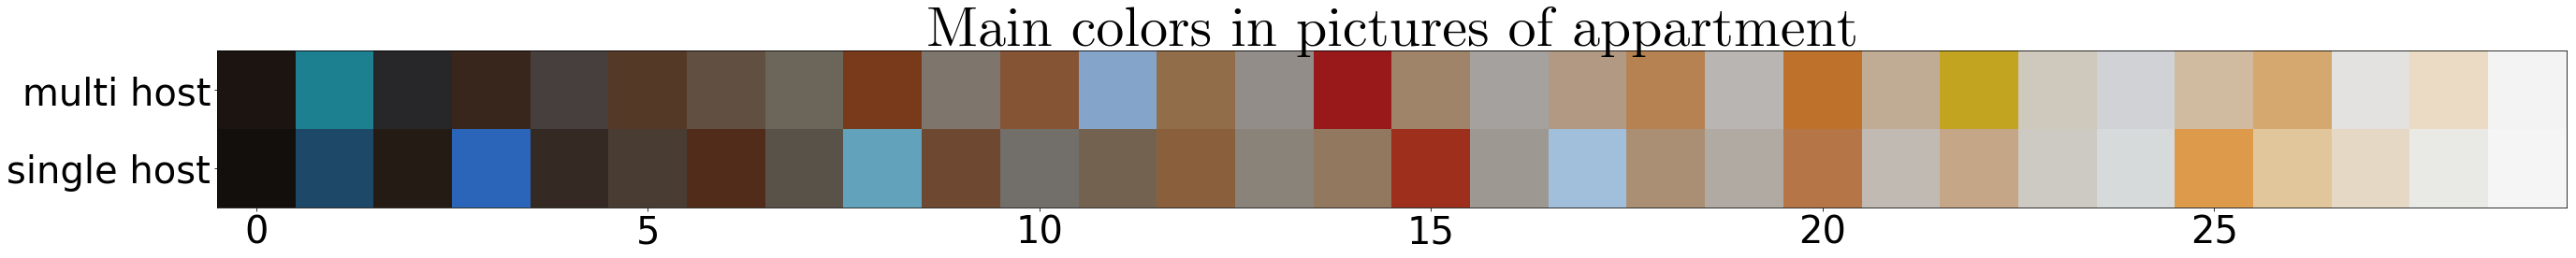

In [78]:
groupy_colors_clusters = df_colors_cluster.groupby('is_multihost')

list_all_colors_clusters = []
for name,group in groupy_colors_clusters:
    print name
    list_all_colors_clusters.append(get_clusters_colors(group, 10,False,n_clusters=30))  
    
fig_size = plt.rcParams["figure.figsize"]
 
plt.figure(figsize=(45,30))

plt.yticks(range(0,11),[str(quantile_name) for quantile_name, _  in groupy_colors_clusters])
plt.tick_params(axis='both', which='major', labelsize=40)

plt.title('Main colors in pictures of appartment', fontsize=60, fontname='CMU Serif')
plt.imshow([c for c in list_all_colors_clusters])

In [14]:
df_colors_cluster.corr()[['review_scores_rating','availability_90']].sort_values(by='availability_90')

,review_scores_rating,availability_90
review_scores_rating,1.000000,-0.125836
reviews_per_month,-0.059182,-0.023410
Centroid_B_4,0.017235,-0.019328
Centroid_G_4,0.010054,-0.018775
Centroid_R_2,-0.017758,-0.018096
Centroid_G_2,-0.013181,-0.015922
Centroid_R_1,-0.030640,-0.015524
Centroid_R_4,0.001515,-0.014687
Centroid_G_3,0.037052,-0.012645
Centroid_B_3,0.036678,-0.012475


In [15]:
cols_int = [col for col in df_colors_cluster.columns if 'Centroid' in col]
cols_int = [col for col in cols_int if 'hex' not in col]

pca = PCA(n_components=6)

X_train = scale(df_colors_cluster[cols_int].values)
y_train = df_colors_cluster['availability_90'].values
z_train = df_colors_cluster['reviews_per_month']*5

X_transformed = pca.fit_transform(X_train)
print pca.explained_variance_ratio_.sum()*100



78.5824933114


In [16]:
df_pca = pd.DataFrame({'PC1':X_transformed[:, 0],'PC2': X_transformed[:, 1], 'availability_90':(y_train),'reviews_per_month':z_train})

In [17]:
df_pca.reviews_per_month=df_pca.reviews_per_month.astype(int)
df_pca.availability_90=df_pca.availability_90.astype(int)

airBColor= '#ff5a5f'
airBColor2='#008489'

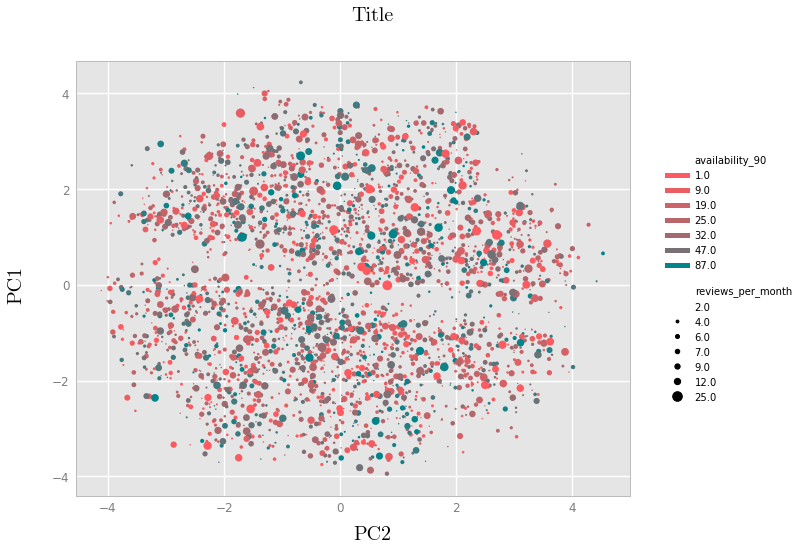

<ggplot: (8774138171241)>

In [46]:
ggplot(df_pca,aes(x='PC1',y='PC2',color='availability_90',size='reviews_per_month'))+geom_point()+scale_color_gradient(low = airBColor, high =airBColor2)+\
ggtitle('PCA for colors clusters')+ theme(plot_title = element_text(size=20, text='Title',family="CMU Serif"), \
        axis_title_y = element_text(size=20, text='PC1',family="CMU Serif"), \
        axis_title_x = element_text(size=20, text='PC2',family="CMU Serif"))

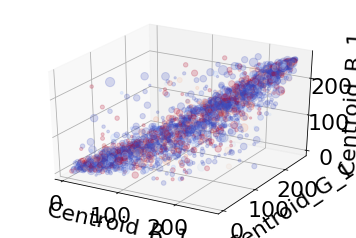

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100
rcParams['figure.figsize'] = 12, 12
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].

colors = plt.cm.coolwarm(scale(df_colors_cluster['availability_90']))

xs = df_colors_cluster['Centroid_R_1']
ys = df_colors_cluster['Centroid_G_1']
zs = df_colors_cluster['Centroid_B_1']
ax.scatter(xs, ys, zs,c=colors,alpha=.2,s=df_colors_cluster['reviews_per_month']*10)


ax.set_xlabel('Centroid_R_1')
ax.set_ylabel('Centroid_G_1')
ax.set_zlabel('Centroid_B_1')



plt.show()


In [20]:
import matplotlib.font_manager
[f.name for f in matplotlib.font_manager.fontManager.ttflist]

[u'CMU Bright',
 u'STIXNonUnicode',
 u'DejaVu Sans',
 u'DejaVu Serif',
 u'CMU Serif Extra',
 u'CMU Typewriter Text Variable Width',
 u'STIXSizeThreeSym',
 u'DejaVu Sans Mono',
 u'CMU Sans Serif',
 u'DejaVu Sans',
 u'CMU Typewriter Text',
 u'CMU Sans Serif',
 u'CMU Bright',
 u'CMU Typewriter Text',
 u'CMU Typewriter Text',
 u'cmtt10',
 u'STIXSizeFourSym',
 u'CMU Bright',
 u'CMU Bright',
 u'DejaVu Sans',
 u'DejaVu Sans Mono',
 u'cmmi10',
 u'DejaVu Sans Mono',
 u'CMU Concrete',
 u'STIXSizeThreeSym',
 u'CMU Sans Serif Demi Condensed',
 u'STIXNonUnicode',
 u'STIXGeneral',
 u'CMU Typewriter Text',
 u'STIXGeneral',
 u'DejaVu Serif',
 u'cmsy10',
 u'STIXSizeOneSym',
 u'DejaVu Serif',
 u'CMU Serif Extra',
 u'CMU Typewriter Text',
 u'CMU Classical Serif',
 u'STIXSizeFiveSym',
 u'STIXGeneral',
 u'STIXSizeTwoSym',
 u'CMU Concrete',
 u'CMU Sans Serif',
 u'CMU Serif',
 u'DejaVu Serif',
 u'CMU Typewriter Text',
 u'STIXSizeTwoSym',
 u'STIXNonUnicode',
 u'CMU Bright',
 u'DejaVu Sans',
 u'CMU Concrete',
